# Lab Assignment Six: Convolutional Network Architectures

## Dataset Selection
Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.

### I choose the image data I used in Lab2.

## Preparation (3 points total)  
- [1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
- [1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [1]:
#import the lib needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
from sklearn.decomposition import PCA
from numpy import random
import skimage
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skimage.feature import daisy
from skimage.feature import match_descriptors
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import average 
from tensorflow.keras.models import  Model

print("numpy version is:",np.__version__)
print("pandas version is:",pd.__version__)
print("Pillow version is:",Image.__version__)
print("skimage version is:",skimage.__version__)

numpy version is: 1.18.5
pandas version is: 1.2.4
Pillow version is: 8.2.0
skimage version is: 0.18.1


In [2]:
%%time
#Because the image files I got is pre-classfied, to meet the requirement of this assignment, I would put 800 each of with-mask image files and without-mask image files into another directory. Since the image files are different sizes, I need to pick the size greater than 128*128 and make it as my dataset after resizing.
path_with_masks = "./data/mask_data/with_mask"
path_without_masks = "./data/mask_data/without_mask"
path_train_uniform_dataset = "./data/mask_data/train_uniform_dataset.nosync"

with_masks_prefix = "with_mask_"
without_mask_prefix = "without_mask_"

files_with_masks = os.listdir(path_with_masks)
files_without_masks = os.listdir(path_without_masks)
print("with_mask original size is:",len(files_with_masks))
print("without_mask original size is:",len(files_without_masks))
pick_img_number = 1000
image_uniform_size = [128,128]#the size of image after resizing

if False == os.path.exists(path_train_uniform_dataset):
    os.mkdir(path_train_uniform_dataset)
    count = 0
    for i in range(len(files_with_masks)):
        #convert image file to RGB color
        img_with_mask_tmp = Image.open(os.path.join(path_with_masks,with_masks_prefix+str(i+1)+".jpg"),'r').convert("RGB")
        img_without_mask_tmp = Image.open(os.path.join(path_without_masks,without_mask_prefix+str(i+1)+".jpg"),'r').convert("RGB")
        img_with_mask_tmp = img_with_mask_tmp.resize(image_uniform_size,Image.ANTIALIAS)
        img_without_mask_tmp = img_without_mask_tmp.resize(image_uniform_size,Image.ANTIALIAS)
        img_with_mask_tmp.save(os.path.join(path_train_uniform_dataset,with_masks_prefix+str(i+1)+".jpg"))
        img_without_mask_tmp.save(os.path.join(path_train_uniform_dataset,without_mask_prefix+str(i+1)+".jpg"))
        count += 1
        if (count>=pick_img_number): break

# for img in os.listdir(path_train_uniform_dataset):
print("train dataset is :",len(os.listdir(path_train_uniform_dataset)))

with_mask original size is: 3710
without_mask original size is: 3828
train dataset is : 2000
CPU times: user 2.99 s, sys: 53.8 ms, total: 3.05 s
Wall time: 3.2 s


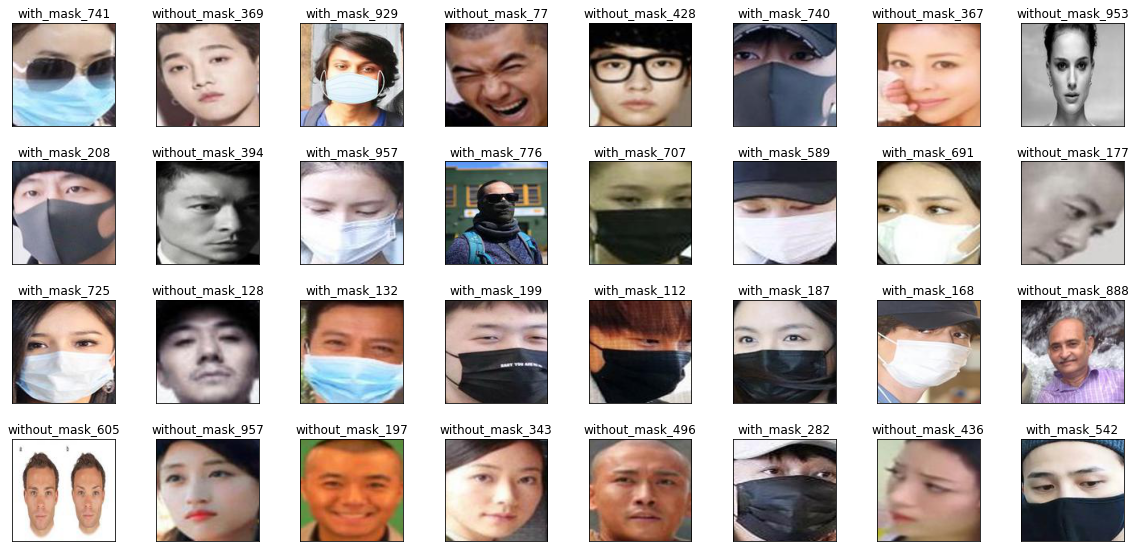

In [22]:
#display several resized images
def plot_raw_gallery(n_row=4, n_col=8):
    plt.figure(figsize=(2*n_col, 2*n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    total = n_row * n_col
    i = 1
    for img_name in os.listdir(path_train_uniform_dataset):
        plt.subplot(n_row, n_col, i)
        img_tmp = plt.imread(os.path.join(path_train_uniform_dataset,img_name))
        plt.imshow(img_tmp)
        plt.title(img_name[:-4], size=12)
        plt.xticks(())
        plt.yticks(())
        i += 1
        if i > total: break

#display some images, copied from "04 Dimension Reduction and Images.ipynb" and made a little adjustment
def plot_gallery(images, titles, h=image_uniform_size[0], w=image_uniform_size[1], n_row=4, n_col=8):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

#display a few images resized
plot_raw_gallery()

In [12]:
%%time
train_img_name_list = os.listdir(path_train_uniform_dataset)

X = np.array([np.array(Image.open(os.path.join(path_train_uniform_dataset,img_name))) for img_name in train_img_name_list])#image data

y = np.array([img_name.count("with_mask_") for img_name in train_img_name_list])#target value

print(X.shape)
print(y.shape)

(2000, 128, 128, 3)
(2000,)
CPU times: user 411 ms, sys: 31.1 ms, total: 442 ms
Wall time: 442 ms


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
%%time
NUM_CLASSES = 2

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=X_train.shape[1], units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: user 20.4 s, sys: 1.71 s, total: 22.1 s
Wall time: 16.4 s


In [23]:
%%time

# make a CNN with conv layer and max pooling
cnn = Sequential() 
cnn.add( Conv2D(filters=16, kernel_size= (2, 2), padding='same', 
                input_shape=(128,128,3),
               data_format="channels_last") )

cnn.add( MaxPooling2D(pool_size=(3, 3), 
                      data_format="channels_first") )
cnn.add( Activation('relu') )
# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )

cnn.summary()

onv2d_3 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 42, 5)        0         
_________________________________________________________________
activation_9 (Activation)    (None, 128, 42, 5)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 26880)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 53762     
_________________________________________________________________
activation_10 (Activation)   (None, 2)                 0         
Total params: 53,970
Trainable params: 53,970
Non-trainable params: 0
_________________________________________________________________
CPU times: user 18.1 ms, sys: 12.1 ms, total: 30.2 ms
Wall time: 29.7 ms


In [24]:
%%time 

print(X_train.shape)
# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn.fit(X_train, y_train, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

(1600, 128, 128, 3)
CPU times: user 26.2 s, sys: 2.08 s, total: 28.2 s
Wall time: 1min 11s


In [25]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('MLP: '+str(acc_mlp))

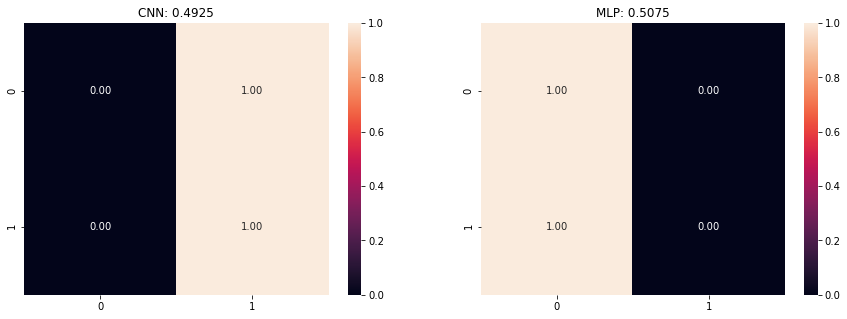

In [26]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

## Modeling (6 points total)
- [1.5 points]  Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 
- [2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).
- [1.5 points] Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 
- [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

## Exceptional Work (1 points total)
- You have free reign to provide additional analyses. 
- One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 